In [50]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from scipy.io import loadmat

from models import Encoder, Decoder, AutoEncoder, AngleDistanceLoss, Discriminator
from utils import MultiplicativeUpdate, VCA

## Experiments on synthetic data

### Generate the data

In [3]:
def gen_data(N_pixels, B, R, plot=False, noise_level=1e-3):
    abundances = nn.functional.normalize(nn.functional.relu(1 + 0.5*torch.randn((N_pixels, R))))
    endmembers = np.zeros((R, B))

    for r in range(R):
        # Generate a gaussian endmember
        mu = np.random.random() * B
        sigma_2 = np.exp(-np.random.random()*3)*B
        endmembers[r] = np.exp(-(np.arange(B)-mu)**2/2/sigma_2)

    endmembers = torch.tensor(endmembers, dtype=torch.float)

    noise = torch.randn(N_pixels, B) * noise_level
    data = abundances @ endmembers + noise

    if plot:
        plt.imshow(endmembers.detach().numpy(), vmin=0)
        plt.title("True endmembers")
        plt.show()
        plt.imshow(abundances.detach().numpy(), vmin=0)
        plt.title("True abundances")
        plt.show()
        plt.imshow(data.detach().numpy(), vmin=0)
        plt.title("True data")
        plt.show()

    return abundances, endmembers, data

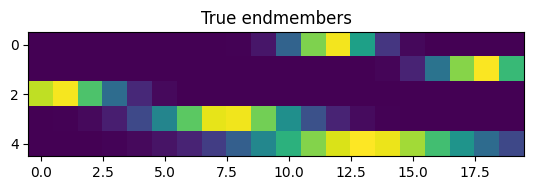

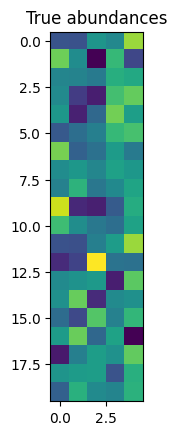

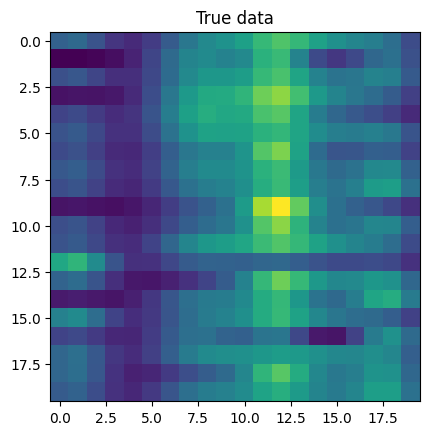

In [4]:
B = 20 # Number of spectral bands
R = 5 # Number of endmembers

N_pixels = 20
torch.manual_seed(0)
np.random.seed(20)
abundances_small, endmembers_small, data_small = gen_data(N_pixels, B, R, plot=True)

N_pixels = 10000
torch.manual_seed(0)
np.random.seed(20)
abundances, endmembers, data = gen_data(N_pixels, B, R, plot=False)

### Comparison of the MSE and SAD losses

In [5]:
def unmix_synthetic_data(data, loss_function, epochs=500, lr=1e-2, betas=(0.9, 0.99), 
                         plot=False, plot_endmembers_only=False):
    encoder = Encoder(B=B, R=R)
    decoder = Decoder(B=B, R=R)
    ae = AutoEncoder(encoder, decoder)

    opti = torch.optim.Adam(ae.parameters(), lr=lr, betas=betas)

    losses = []

    # Training loop
    for e in tqdm(range(epochs)):
        opti.zero_grad()
        embeddings, reconstruct = ae(data)
        loss = loss_function(reconstruct, data)
        loss.backward()
        opti.step()
        ae.projection()

        losses.append(loss.detach().numpy())

    # Final evaluation
    with torch.no_grad():
        embeddings, reconstruct = ae(data)
        loss = loss_function(reconstruct, data)

    est_endmembers = decoder.W.detach().numpy()
    est_abundances = embeddings.detach().numpy()
    reconstruct = reconstruct.detach().numpy()
    
    if plot:
        print("Final loss", loss.numpy())
        if not plot_endmembers_only:
            plt.plot(losses)
            plt.title("Loss")
            plt.show()

        plt.imshow(est_endmembers, vmin=0)
        plt.title("Estimated endmembers")
        plt.show()

        if not plot_endmembers_only:
            plt.imshow(est_abundances, vmin=0)
            plt.title("Estimated abundances")
            plt.show()
            plt.imshow(reconstruct, vmin=0)
            plt.title("Reconstruction")
            plt.show()

    return est_endmembers, est_abundances, reconstruct, losses

100%|██████████| 500/500 [00:01<00:00, 480.77it/s]


Final loss 0.0016794583


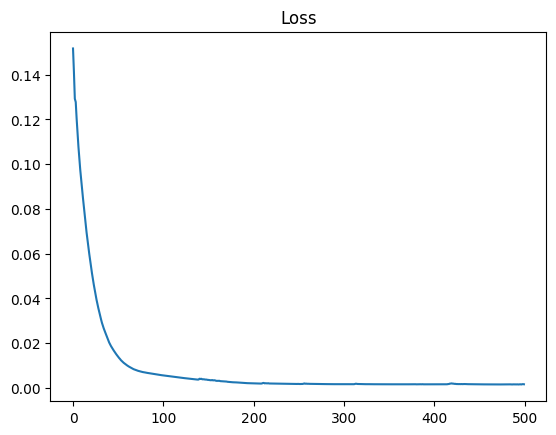

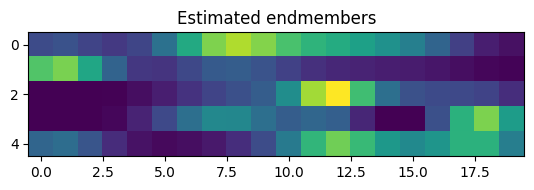

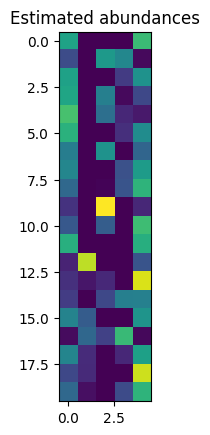

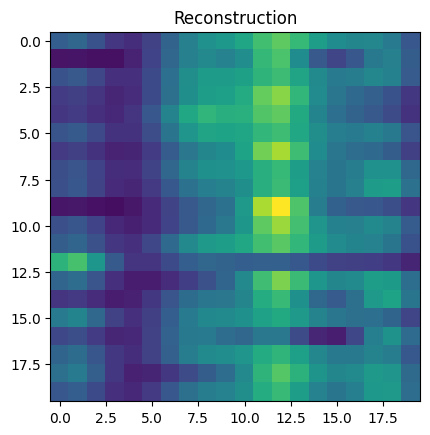

100%|██████████| 500/500 [00:07<00:00, 62.90it/s]


Final loss 0.0008078726


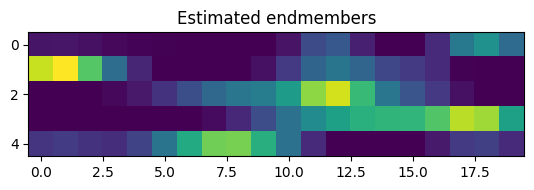

In [6]:
ret_small_mse = unmix_synthetic_data(data_small, nn.MSELoss(), plot=True)
ret_mse = unmix_synthetic_data(data, nn.MSELoss(), plot=True, plot_endmembers_only=True)

100%|██████████| 500/500 [00:01<00:00, 446.36it/s]

Final loss 0.038471814


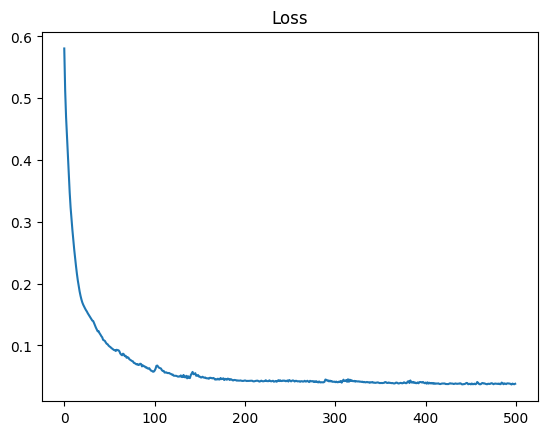

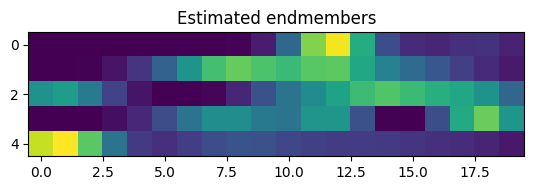

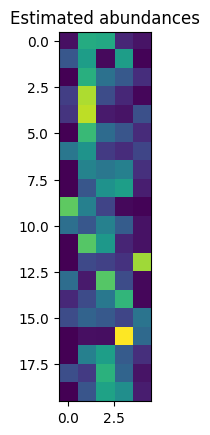

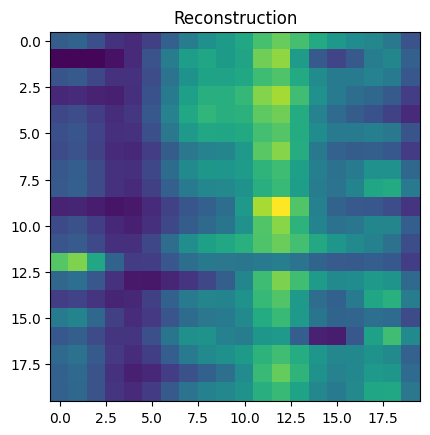

100%|██████████| 500/500 [00:09<00:00, 54.18it/s]


Final loss 0.0085092755


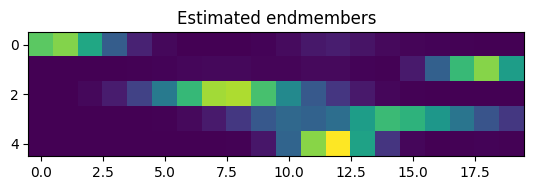

In [7]:
ret_small_sad = unmix_synthetic_data(data_small, AngleDistanceLoss(), plot=True)
ret_sad = unmix_synthetic_data(data, AngleDistanceLoss(), plot=True, plot_endmembers_only=True)

## Load real data

### Jasper image

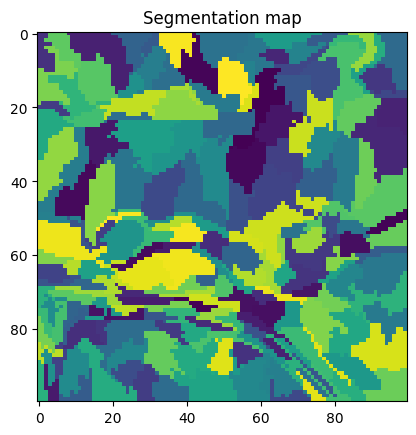

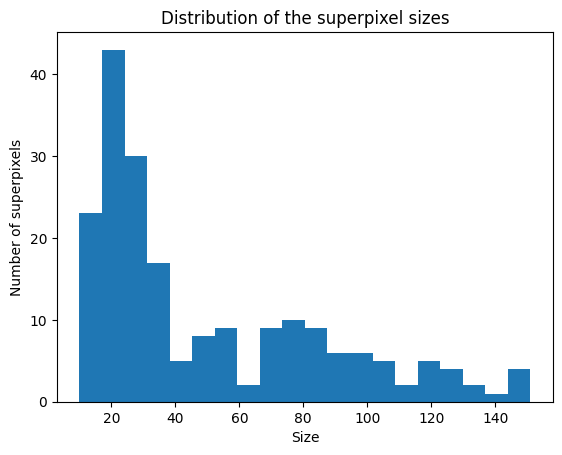

In [27]:
jasper = loadmat("../data/jasper/jasper.mat")
jasper["Y"] = jasper["Y"] / jasper["Y"].max()
jasper_cube = jasper["Y"].reshape(jasper["nBand"][0, 0], jasper["nRow"][0, 0], jasper["nCol"][0, 0])
jasper_cube = jasper_cube[jasper["SlectBands"].reshape(-1)]
B_jasper = len(jasper_cube)

jasper_segmentation_map = np.load("../data/jasper/jasper_200_seg.npy")
K = jasper_segmentation_map.max()
plt.imshow(jasper_segmentation_map)
plt.title("Segmentation map")
plt.show()

jasper_superpixels = {}
for i in range(jasper["nRow"][0, 0]):
    for j in range(jasper["nCol"][0, 0]):
        ind = jasper_segmentation_map[i, j]
        if ind not in jasper_superpixels:
            jasper_superpixels[ind] = []
        jasper_superpixels[ind].append(jasper_cube[:, i, j])

jasper_lens = [len(jasper_superpixels[s]) for s in jasper_superpixels]

plt.hist(jasper_lens, bins=20)
plt.title("Distribution of the superpixel sizes")
plt.xlabel("Size")
plt.ylabel("Number of superpixels")
plt.show()

#### VCA endmembers extraction

Max residual 0.16479817727003832


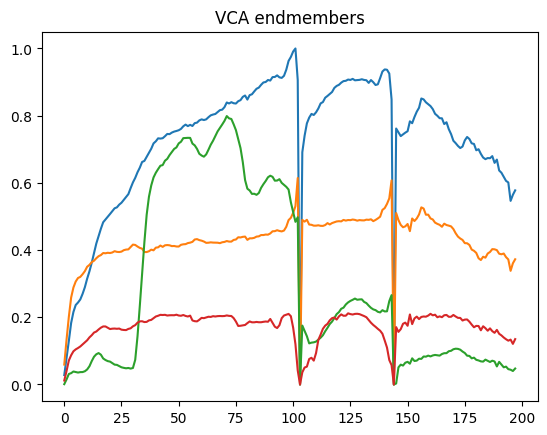

In [28]:
R_jasper = 4 # number of endmembers
np.random.seed(3)
japser_flat = jasper["Y"][jasper["SlectBands"].reshape(-1)]
jasper_endmembers_indices = VCA(japser_flat, R_jasper)
jasper_vca_endmembers = japser_flat[:, jasper_endmembers_indices]
plt.plot(jasper_vca_endmembers)
plt.title("VCA endmembers")
plt.show()

#### Statistics of abundances in each superpixel

In [29]:
jasper_means = []
jasper_sqrt_cov = []
eps = 1e-5
nb_none = 0

#VCA_endmembers = torch.tensor(VCA_endmembers, requires_grad=False, dtype=torch.float)
for i in tqdm(jasper_superpixels):
    jasper_superpixels[i] = np.array(jasper_superpixels[i])
    abundances = MultiplicativeUpdate(jasper_superpixels[i].T, A=jasper_vca_endmembers, frozenA=True)[1]

    jasper_superpixels[i] = torch.tensor(jasper_superpixels[i], dtype=torch.float)
    abundances = torch.tensor(abundances, dtype=torch.float)
    mean = abundances.mean(axis=1)
    jasper_means.append(mean)

    centered_abundances = (abundances.T - mean).T
    cov = centered_abundances @ centered_abundances.T
    sqrt = torch.linalg.cholesky(cov + torch.eye(len(mean))*eps).T

    jasper_sqrt_cov.append(sqrt)


100%|██████████| 200/200 [00:35<00:00,  5.66it/s]


### Samson image

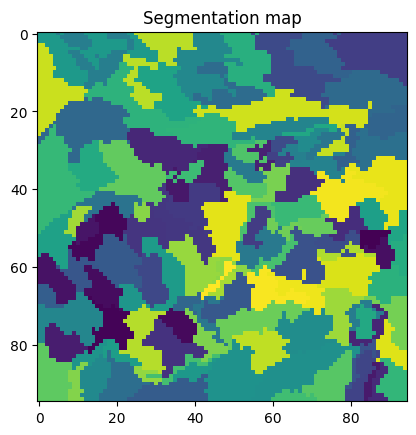

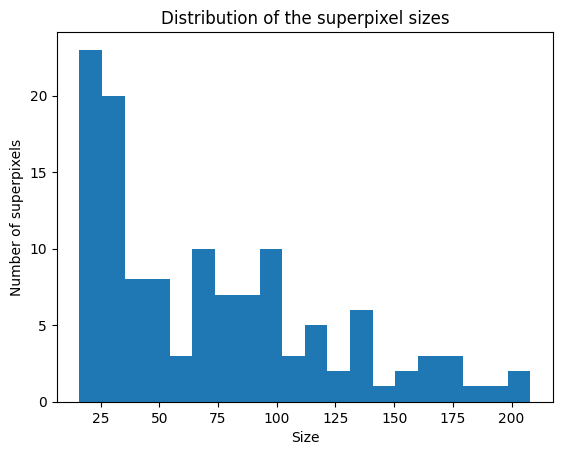

In [30]:
samson = loadmat("../data/samson/samson.mat")
samson["V"] = samson["V"] / samson["V"].max()
samson_flat = samson["V"]
samson_cube = samson["V"].reshape(samson["nBand"][0, 0], samson["nRow"][0, 0], samson["nCol"][0, 0])
B_samson = len(samson_cube)

samson_segmentation_map = np.load("../data/samson/samson_125_seg.npy")
K = samson_segmentation_map.max()
plt.imshow(samson_segmentation_map)
plt.title("Segmentation map")
plt.show()

samson_superpixels = {}
for i in range(samson["nRow"][0, 0]):
    for j in range(samson["nCol"][0, 0]):
        ind = samson_segmentation_map[i, j]
        if ind not in samson_superpixels:
            samson_superpixels[ind] = []
        samson_superpixels[ind].append(samson_cube[:, i, j])

lens = [len(samson_superpixels[s]) for s in samson_superpixels]

plt.hist(lens, bins=20)
plt.title("Distribution of the superpixel sizes")
plt.xlabel("Size")
plt.ylabel("Number of superpixels")
plt.show()

#### VCA endmembers extraction

Max residual 0.10055251581198828


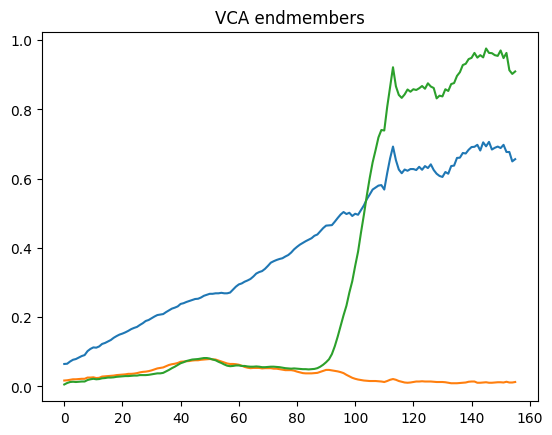

In [31]:
R_samson = 3 # number of endmembers
np.random.seed(9)
samson_endmembers_indices = VCA(samson["V"], R_samson)
samson_vca_endmembers = samson["V"][:, samson_endmembers_indices]
plt.plot(samson_vca_endmembers)
plt.title("VCA endmembers")
plt.show()

#### Statistics of abundances in each superpixel

In [32]:
samson_means = []
samson_sqrt_cov = []
eps = 1e-5
nb_none = 0

for i in tqdm(samson_superpixels):
    samson_superpixels[i] = np.array(samson_superpixels[i])
    abundances = MultiplicativeUpdate(samson_superpixels[i].T, A=samson_vca_endmembers, frozenA=True)[1]

    samson_superpixels[i] = torch.tensor(samson_superpixels[i], dtype=torch.float)
    abundances = torch.tensor(abundances, dtype=torch.float)
    mean = abundances.mean(axis=1)
    samson_means.append(mean)

    centered_abundances = (abundances.T - mean).T
    cov = centered_abundances @ centered_abundances.T
    sqrt = torch.linalg.cholesky(cov + torch.eye(len(mean))*eps).T

    samson_sqrt_cov.append(sqrt)


100%|██████████| 125/125 [00:27<00:00,  4.51it/s]


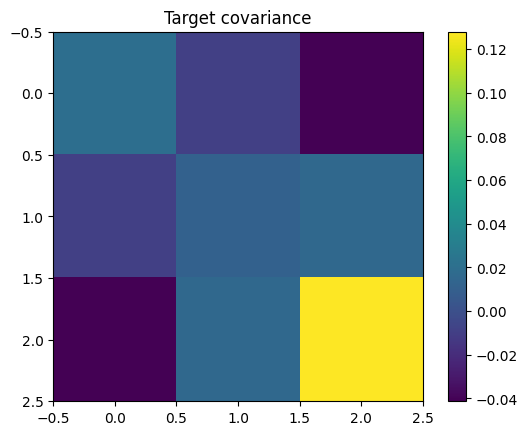

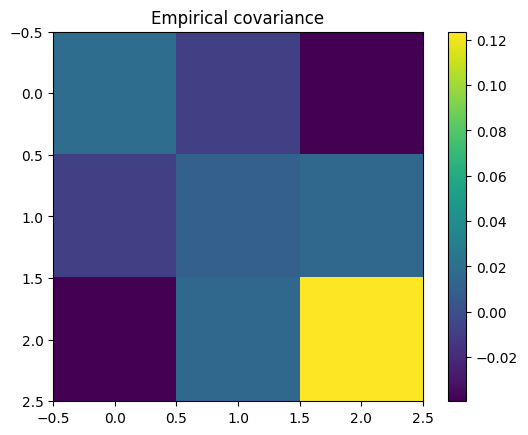

In [33]:
sqrt = samson_sqrt_cov[np.random.randint(0, len(samson_sqrt_cov))]
plt.imshow((sqrt @ sqrt.T).detach().numpy())
plt.title("Target covariance")
plt.colorbar()
plt.show()

noise = np.random.randn(1000, 3)
samples = noise @ sqrt.detach().numpy().T
empirical_cov = (samples.T @ samples)/1000
plt.imshow(empirical_cov)
plt.title("Empirical covariance")
plt.colorbar()
plt.show()

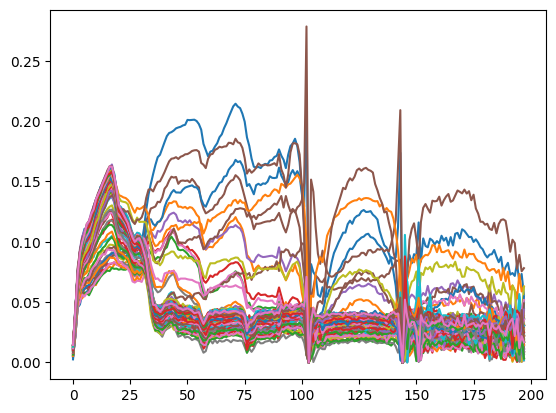

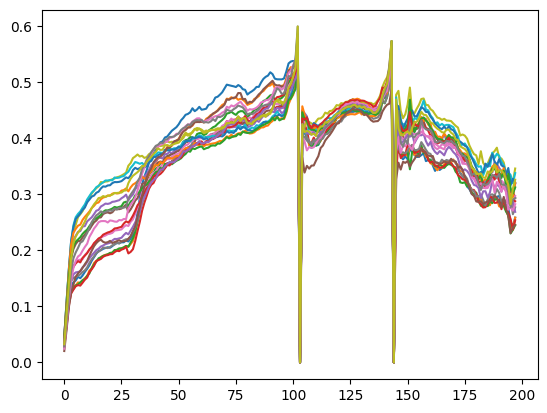

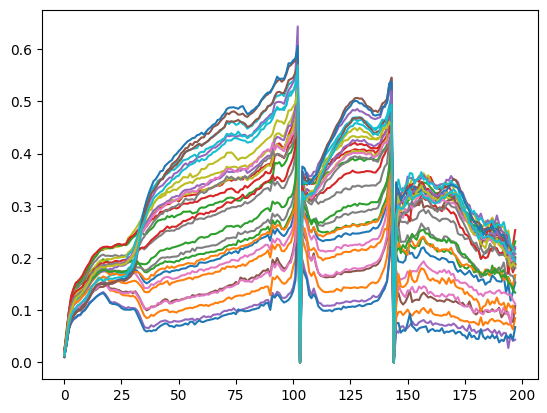

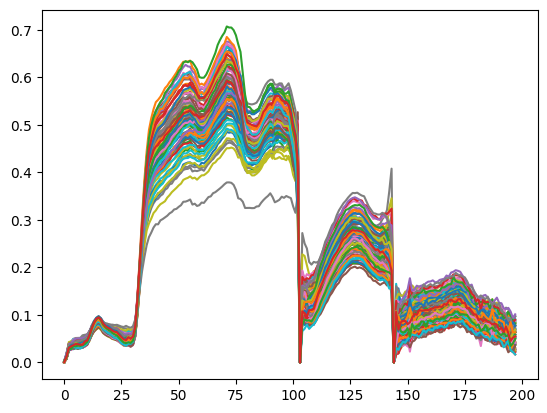

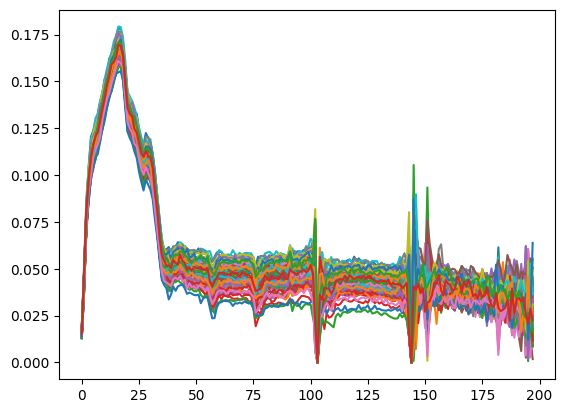

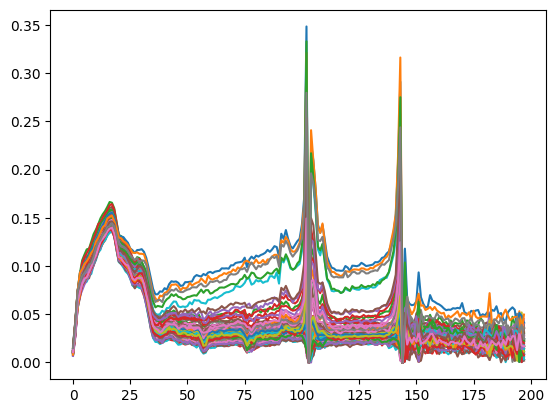

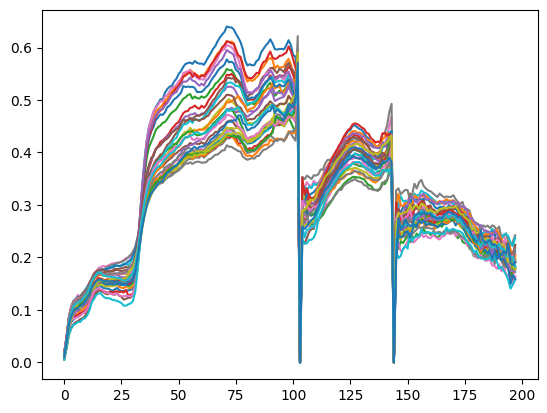

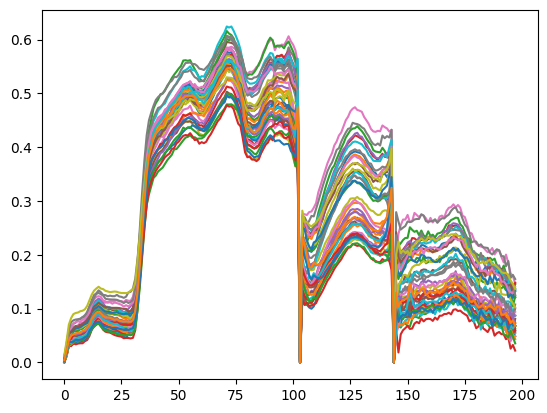

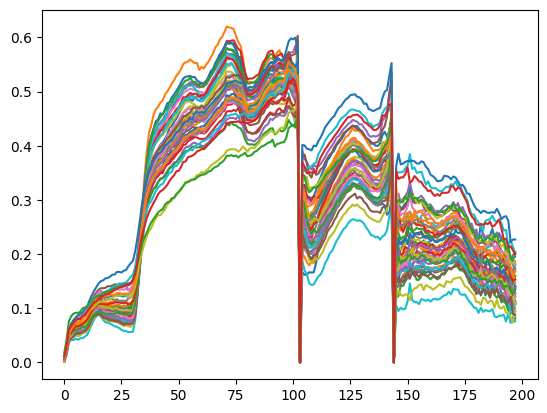

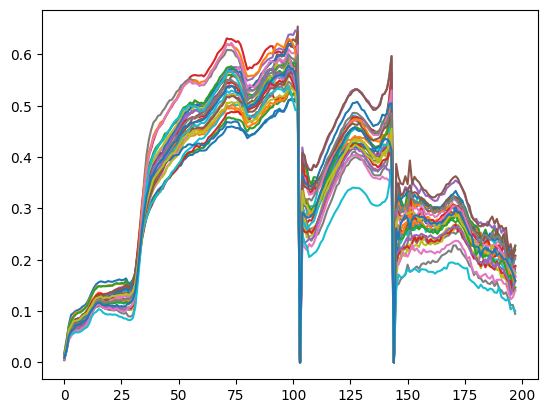

In [34]:
for i in range(10):
    plt.plot(jasper_superpixels[i].detach().numpy().T)
    plt.show()

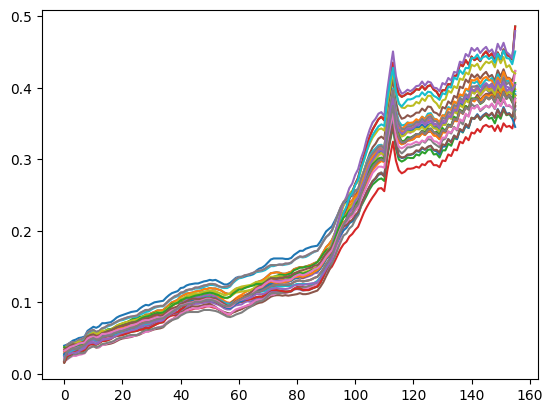

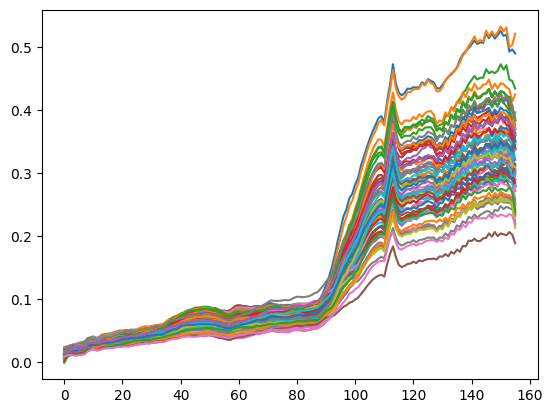

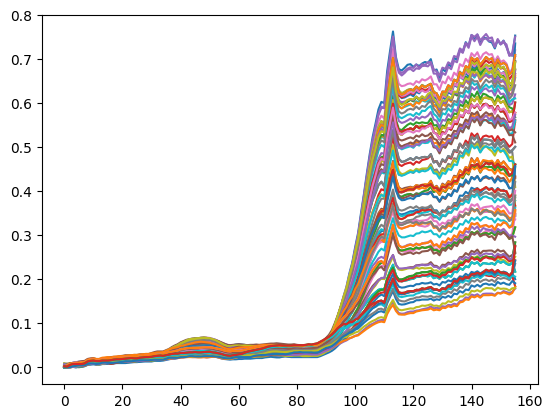

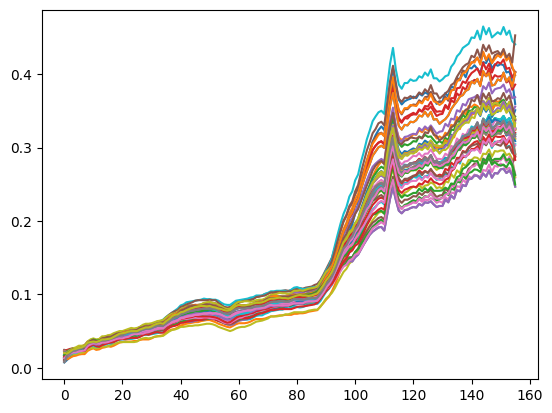

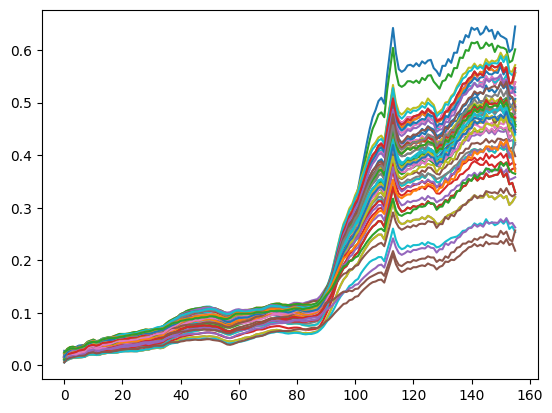

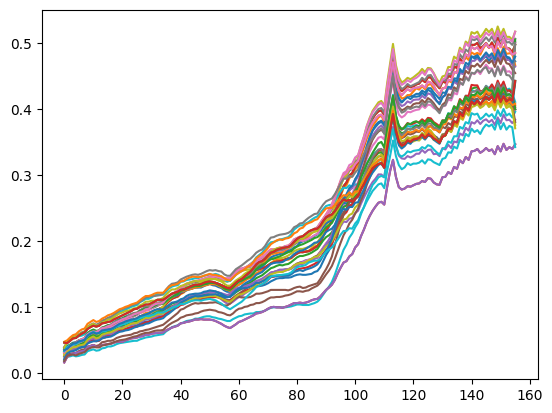

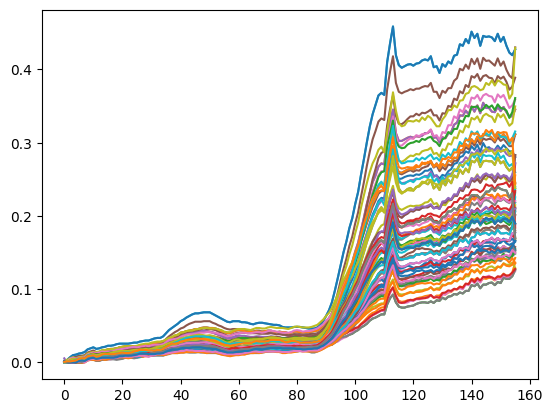

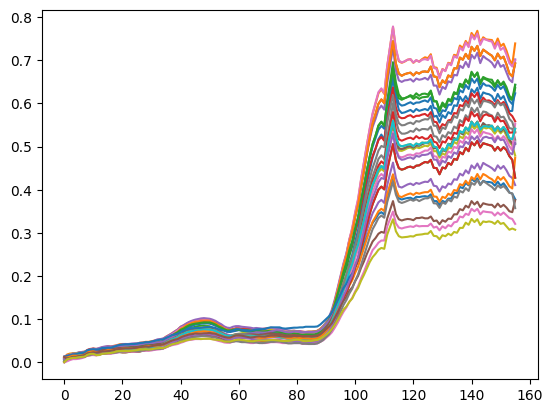

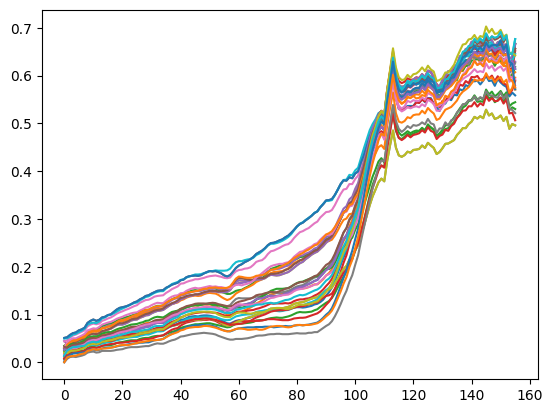

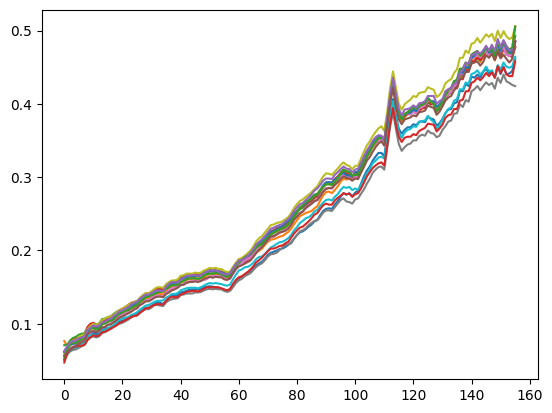

In [35]:
for i in range(10):
    plt.plot(samson_superpixels[i].detach().numpy().T)
    plt.show()

## Train the autoencoder without adversarial regularization

In [40]:
def train_autoencoder(ae, superpixels, VCA_endmembers, epochs, lamb, R):
        
    sad = AngleDistanceLoss()
    opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

    mse_vca = []
    losses_vca = []
    losses_rec = []
    losses = []

    for e in tqdm(range(epochs)):
        loss_epoch = 0
        loss_vca_epoch = 0
        loss_rec_epoch = 0
        for b in range(len(superpixels)):
            opti.zero_grad()

            # Regularization w.r.t VCA endmembers
            loss_vca = sad(ae.decoder.W, VCA_endmembers.T)
            loss_vca_epoch += loss_vca.detach().cpu().numpy()
            loss_vca = lamb * loss_vca
            loss_vca.backward()
            ae.decoder.W.grad[ae.decoder.W.grad.isnan()] = 0
            
            # Train the reconstruction
            reconstruct = ae(superpixels[b])[1]
            loss_rec = sad(reconstruct, superpixels[b]) 
            loss_rec_epoch += loss_rec.detach().cpu().numpy()
            loss_rec.backward()
            
            opti.step()
            ae.projection()

            loss = loss_rec.detach().cpu().numpy() + loss_vca.detach().cpu().numpy()
            loss_epoch += loss
            
        losses_vca.append(loss_vca_epoch / len(superpixels))
        losses_rec.append(loss_rec_epoch / len(superpixels))
        losses.append(loss_epoch / len(superpixels))
        mse_vca.append(np.linalg.norm(ae.decoder.W.detach() - VCA_endmembers.T))

    print("VCA loss:", losses_vca[-1])
    print("Reconstruction loss:", losses_rec[-1])
    print("Total loss:", losses[-1])
    
    plt.plot(losses_vca, label="Endmembers loss", color="blue")
    plt.plot(losses_rec, label="Reconstruction loss", color="green")
    plt.plot(losses, label="Total loss", color="red")
    plt.legend()
    plt.xlabel("Epochs")
    plt.title("Autoencoder loss, $\lambda$="+str(lamb))
    plt.show()

    ref_endmembers = VCA_endmembers.detach().numpy()
    dec_endmembers = ae.decoder.W.detach().numpy().T

    for i in range(R):
        plt.plot(ref_endmembers[:,i], color=plt.cm.tab10(i), linewidth=0.9)
        plt.plot(dec_endmembers[:,i], color=plt.cm.tab10(i), linestyle="--")
    plt.title("VCA (solid lines) vs decoder (dashed lines), $\lambda$="+str(lamb))
    plt.show()


### Jasper image

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

VCA loss: 0.06779808629304171
Reconstruction loss: 0.23736566256731748
Total loss: 0.24414547182619573


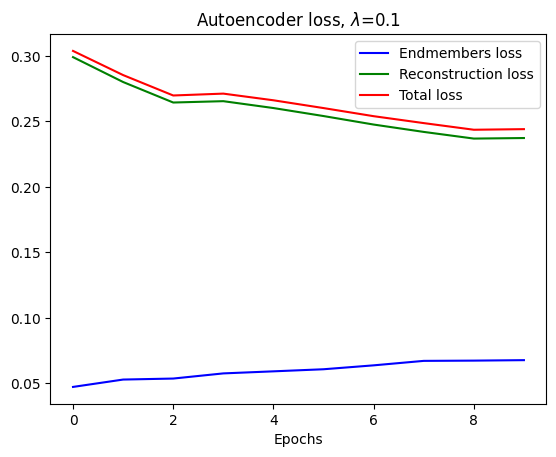

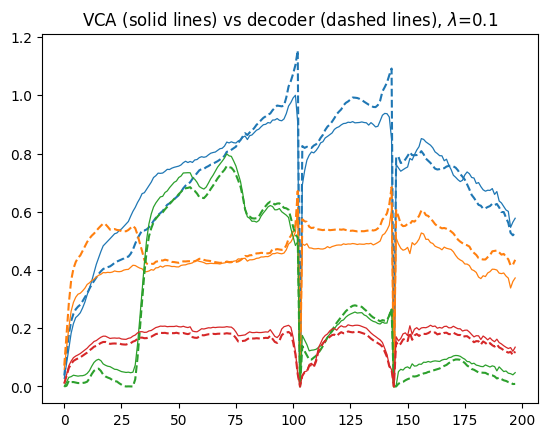

In [49]:
lamb = 0.1
epochs = 10

encoder = Encoder(B=B_jasper, R=R_jasper)
decoder = Decoder(B=B_jasper, R=R_jasper, init_endmembers=torch.tensor(jasper_vca_endmembers, dtype=torch.float).T, 
                  freeze=False)
ae = AutoEncoder(encoder, decoder)

train_autoencoder(ae, jasper_superpixels, 
                  torch.tensor(jasper_vca_endmembers, dtype=torch.float),
                  epochs, lamb, R_jasper)

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


VCA loss: 0.25516877345740796
Reconstruction loss: 0.21823859050869943
Total loss: 0.22079027842730284


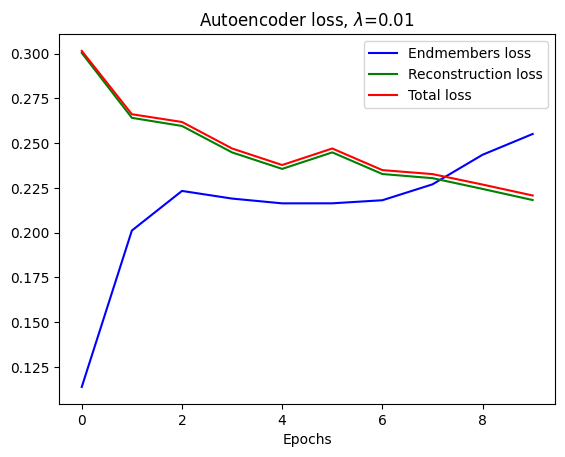

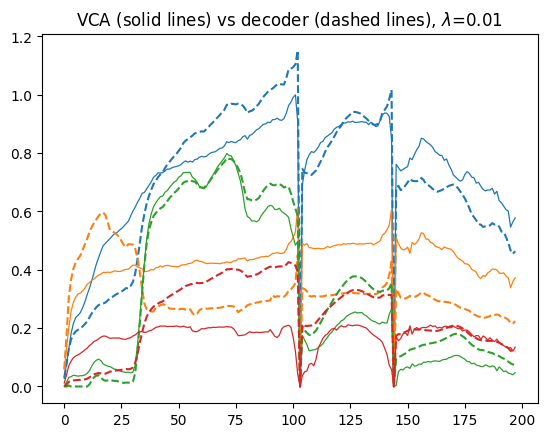

In [42]:
lamb = 0.01
epochs = 10

encoder = Encoder(B=B_jasper, R=R_jasper)
decoder = Decoder(B=B_jasper, R=R_jasper, init_endmembers=torch.tensor(jasper_vca_endmembers, dtype=torch.float).T, 
                  freeze=False)
ae = AutoEncoder(encoder, decoder)

train_autoencoder(ae, jasper_superpixels, 
                  torch.tensor(jasper_vca_endmembers, dtype=torch.float),
                  epochs, lamb, R_jasper)

### Samson image

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


VCA loss: 0.06331950825452805
Reconstruction loss: 0.15836980748176574
Total loss: 0.1647017589509487


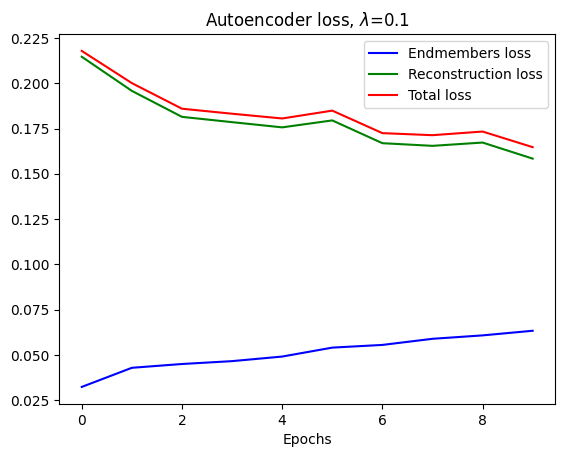

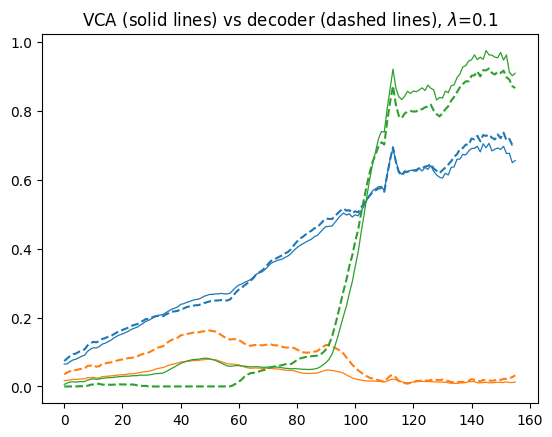

In [48]:
lamb = 0.1
epochs = 10

encoder = Encoder(B=B_samson, R=R_samson)
decoder = Decoder(B=B_samson, R=R_samson, init_endmembers=torch.tensor(samson_vca_endmembers, dtype=torch.float).T, 
                  freeze=False)
ae = AutoEncoder(encoder, decoder)

train_autoencoder(ae, samson_superpixels, 
                  torch.tensor(samson_vca_endmembers, dtype=torch.float),
                  epochs, lamb, R_samson)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


VCA loss: 0.4619500665664673
Reconstruction loss: 0.16949050027132034
Total loss: 0.17411000180244446


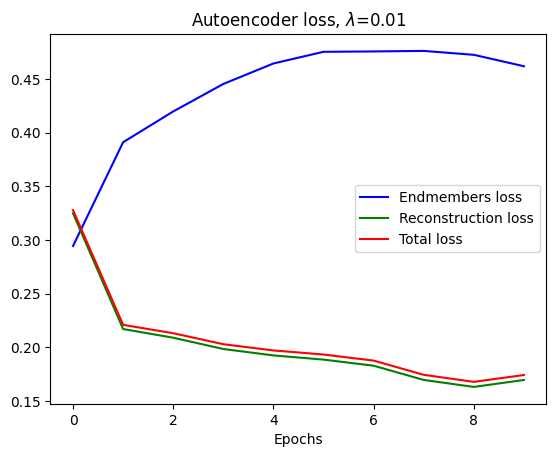

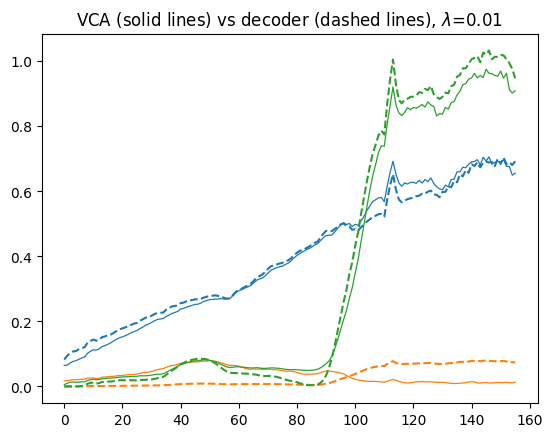

In [46]:
lamb = 0.01
epochs = 10

encoder = Encoder(B=B_samson, R=R_samson)
decoder = Decoder(B=B_samson, R=R_samson, init_endmembers=torch.tensor(samson_vca_endmembers, dtype=torch.float).T, 
                  freeze=False)
ae = AutoEncoder(encoder, decoder)

train_autoencoder(ae, samson_superpixels, 
                  torch.tensor(samson_vca_endmembers, dtype=torch.float),
                  epochs, lamb, R_samson)

## Adversarial regularization with the AAENet

In [53]:
def train_aaenet(ae, discriminator, superpixels, means, sqrt_cov, 
                      VCA_endmembers, epochs, lamb_VCA, lamb_gen, R):
    
    sad = AngleDistanceLoss()
    bceLogits = nn.BCEWithLogitsLoss()

    # Optimizer for autoencoder
    opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

    # Optimizer for discriminator
    opti_D = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.9, 0.99))

    losses_SAD = []
    losses_VCA = []
    losses_G = []
    losses_D = []

    for e in tqdm(range(epochs)):
        loss_SAD_epoch = 0
        loss_VCA_epoch = 0
        loss_G_epoch = 0
        loss_D_epoch = 0

        for b in range(len(superpixels)):
            opti.zero_grad()

            # Regularization w.r.t VCA endmembers
            loss_VCA = sad(ae.decoder.W, VCA_endmembers.T)
            loss_VCA_epoch += loss_VCA.detach().cpu().numpy()
            loss_VCA = lamb_VCA * loss_VCA
            loss_VCA.backward()
            ae.decoder.W.grad[ae.decoder.W.grad.isnan()] = 0
            
            # Train the reconstruction
            embeddings, reconstruct = ae(superpixels[b])
            loss_SAD = sad(reconstruct, superpixels[b]) 
            loss_SAD_epoch += loss_SAD.detach().cpu().numpy()
            loss_SAD.backward()
            
            opti.step()
            ae.projection()

            opti.zero_grad()
            
            # Regularization using the discriminator
            embeddings, reconstruct = ae(superpixels[b])
            pred = discriminator(embeddings)
            loss_G = -bceLogits(pred, torch.zeros((len(superpixels[b]), 1), dtype=torch.float))
            loss_G_epoch += loss_G.detach().cpu().numpy()
            loss_G = lamb_gen*loss_G
            loss_G.backward()
            #opti.step()
            ae.projection()

            # Train the discriminator
            opti_D.zero_grad()
            embeddings, reconstruct = ae(superpixels[b])
            pred = discriminator(embeddings)
            
            # Generate positive samples:
            pos_samples = means[b] + torch.randn(len(superpixels[b]), R) @ sqrt_cov[b].T 
            pos_pred = discriminator(pos_samples)
            neg_pred = discriminator(embeddings.detach())

            loss_D_pos = bceLogits(pos_pred, torch.ones((len(superpixels[b]), 1), dtype=torch.float)) 
            loss_D_neg = bceLogits(neg_pred, torch.zeros((len(superpixels[b]), 1), dtype=torch.float))
            loss_D = loss_D_pos + loss_D_neg
            loss_D.backward()
            opti_D.step()

            loss_D_epoch += loss_D.detach().numpy()   

        losses_D.append(loss_D_epoch / len(superpixels))
        losses_SAD.append(loss_SAD_epoch / len(superpixels))
        losses_VCA.append(loss_VCA_epoch / len(superpixels))
        losses_G.append(loss_G_epoch / len(superpixels))


    plt.plot(losses_SAD, label="Reconstrction SAD", color="red")
    plt.plot(losses_VCA, label="VCA", color="green")
    plt.legend()
    plt.title("Autoencoder losses")
    plt.show()

    plt.plot(losses_D, label="Discriminator", color="black")
    plt.plot(losses_G, label="Generator", color="blue")
    plt.legend()
    plt.title("Adversarial losses")
    plt.show()

100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


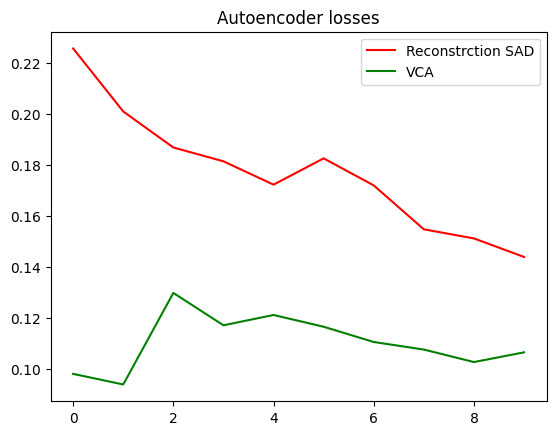

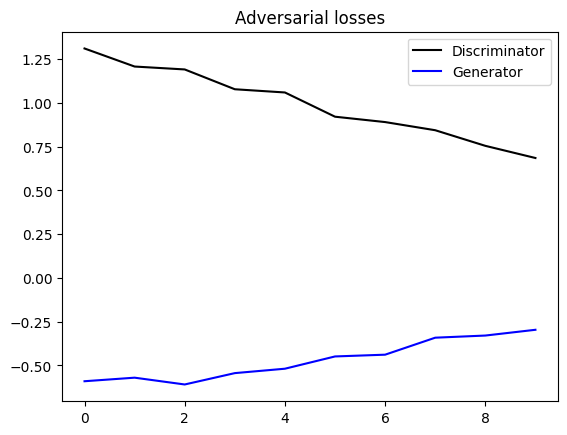

In [54]:
lamb_VCA = 0.01
lamb_gen = 0.1
epochs = 10

encoder = Encoder(B=B_samson, R=R_samson)
decoder = Decoder(B=B_samson, R=R_samson, 
                  init_endmembers=torch.tensor(samson_vca_endmembers, dtype=torch.float).T, 
                  freeze=False)
ae = AutoEncoder(encoder, decoder)
discriminator = Discriminator(B=B_samson, R=R_samson)

train_aaenet(ae, discriminator, samson_superpixels, samson_means, samson_sqrt_cov, 
             torch.tensor(samson_vca_endmembers, dtype=torch.float),
             epochs, lamb_VCA, lamb_gen, R_samson)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


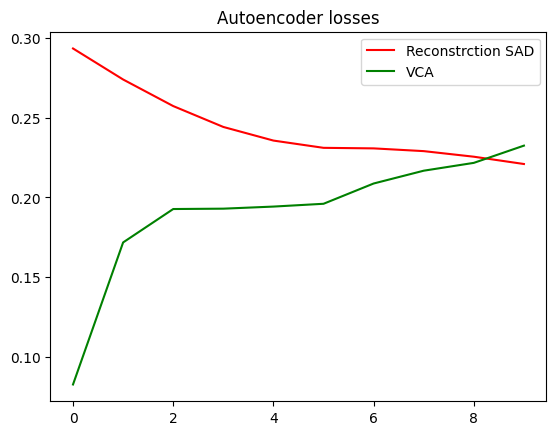

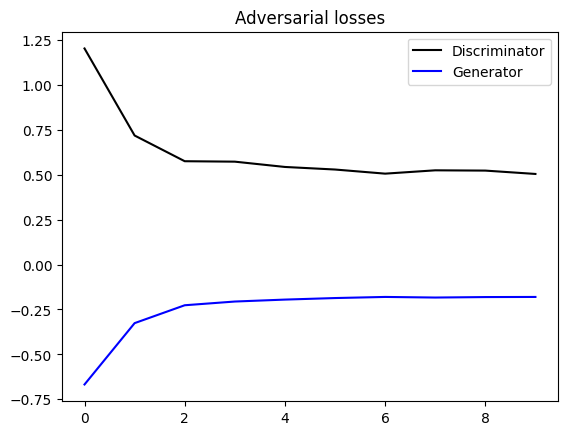

In [56]:
lamb_VCA = 0.01
lamb_gen = 0.1
epochs = 10

encoder = Encoder(B=B_jasper, R=R_jasper)
decoder = Decoder(B=B_jasper, R=R_jasper, 
                  init_endmembers=torch.tensor(jasper_vca_endmembers, dtype=torch.float).T, 
                  freeze=False)
ae = AutoEncoder(encoder, decoder)
discriminator = Discriminator(B=B_jasper, R=R_jasper)

train_aaenet(ae, discriminator, jasper_superpixels, jasper_means, jasper_sqrt_cov, 
             torch.tensor(jasper_vca_endmembers, dtype=torch.float),
             epochs, lamb_VCA, lamb_gen, R_jasper)